In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import time
import math

## I. Creating Somewhat Realistic Sample Information

In [2]:

# User-specific information
distance_unit = 'Kilometer'
route_length = 42 # the length of the route back to the starting point
minimum_fare = 13 # the fare passengers pay for the first minimum_distance kilometers
minimum_distance = 4 # distances longer than this require additional payment
additional_charge_per_km = 1.50 # the fare passengers pay for each succeeding kilometer

# Number of passengers for the day
n = 16000

# We are assuming that the number of passengers is dominated by commuting workers and students going to and from work and school respectively
# Therefore, the boarding time distribution is bimodal centered around 0700 and 1700
mu_time, sigma_time = 7, 3.75
mu2_time, sigma2_time = 17, 4.01
normal_time = np.random.normal(mu_time, sigma_time, n // 2)
normal2_time = np.random.normal(mu2_time, sigma2_time, n // 2)

# We are assuming that most passengers come from densely populated areas, and the route starting and midway segments usually are
# Therefore, the boarding place distribution is bimodal centered around 1 and route_length / 2
mu_place, sigma_place = 1, 3.87
mu2_place, sigma2_place = route_length / 2, 4.31
normal_place = np.random.normal(mu_place, sigma_place, n // 2)
normal2_place = np.random.normal(mu2_place, sigma2_place, n // 2)

# Removing invalid values (Time is only between 0000 and 2400)
for i in range(len(normal_time)):
    if normal_time[i] < 0 or normal_time[i] > 24:
        normal_time[i] = mu_time

for i in range(len(normal2_time)):
    if normal2_time[i] < 0 or normal2_time[i] > 24:
        normal2_time[i] = mu2_time

# Removing invalid values (Place is only between 0 and 42)
for i in range(len(normal_place)):
    if normal_place[i] < 0:
        normal_place[i] += 2 * (mu_place - normal_place[i])
    if normal_place[i] > route_length:
        normal_place[i] -= 2 * (normal_place[i] - mu_place)

for i in range(len(normal2_place)):
    if normal2_place[i] < 0:
        normal2_place[i] += 2 * (mu2_place - normal2_place[i])
    if normal2_place[i] > route_length:
        normal2_place[i] -= 2 * (normal2_place[i] - mu2_place)

bimodal_time = np.concatenate([normal_time, normal2_time])
bimodal_place = np.concatenate([normal_place, normal2_place])

# Turning the random numbers into random time objects and adding them to a DataFrame
info_dict = {'boarding_time': [], 'boarding_place': [], 'boarding_payment': []}

for i in bimodal_time:
    hour = int(i)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    info_dict['boarding_time'].append(time(hour, minute, second))

for i in bimodal_place:
    place = int(i)
    info_dict['boarding_place'].append(place)
    travel_distance = random.randint(0, route_length - place)
    if travel_distance <= minimum_distance:
        info_dict['boarding_payment'].append(minimum_fare)
    else:
        info_dict['boarding_payment'].append(minimum_fare + additional_charge_per_km * (travel_distance - minimum_distance))


## II. Infering The Needed Information From The Sample Data

In [3]:
# A typical information sheet contains when passengers board, where passengers board, and how much passengers paid
df = pd.DataFrame(info_dict)

# Clean up and getting the boarding hour to simplify visualizations
df_cleaned = df.sort_values('boarding_time')
df_cleaned.reset_index(inplace = True)
df_cleaned.drop('index', axis = 1, inplace = True)
df_cleaned['boarding_hour'] = df_cleaned['boarding_time'].apply(lambda x: x.hour)

# Calculate how many passengers we get per kilometer-hour
passenger_distribution = df_cleaned.pivot_table(index="boarding_hour", columns="boarding_place", aggfunc = 'size', fill_value=0)

# Calculate how much we earn per kilometer-hour
income_distribution = df_cleaned.pivot_table(index="boarding_hour", columns="boarding_place", values="boarding_payment", aggfunc = 'sum', fill_value=0)

# Calculating the minimum number of public utility vehicles needed to satisfy the demand by the hour
vehicle_capacity = 20 # Max capacity of a standard public utility vehicle
passenger_per_hour = passenger_distribution.T
passenger_per_hour.loc['Total Passengers'] = passenger_per_hour.sum()
minimum_vehicles = passenger_per_hour.loc['Total Passengers'].apply(lambda x: math.ceil(x / vehicle_capacity))
minimum_vehicles = minimum_vehicles.to_frame()
minimum_vehicles = minimum_vehicles.rename(columns = {'Total Passengers': 'Minimum Vehicles'})

## III. Displaying Of Data And Visualizations

In [4]:
# Sample data we are working on
df

,boarding_time,boarding_place,boarding_payment
0,15:54:09,5,13.0
1,07:47:47,1,13.0
2,01:53:33,4,14.5
3,02:57:50,4,16.0
4,07:40:59,4,13.0
...,...,...,...
15995,23:04:22,14,13.0
15996,11:28:26,25,23.5
15997,12:47:51,21,28.0
15998,21:38:45,21,23.5


In [5]:
# Cleaned data
df_cleaned

,boarding_time,boarding_place,boarding_payment,boarding_hour
0,00:00:00,0,26.5,0
1,00:00:24,7,26.5,0
2,00:00:39,2,20.5,0
3,00:01:20,3,46.0,0
4,00:01:50,8,29.5,0
...,...,...,...,...
15995,23:57:31,12,37.0,23
15996,23:57:41,25,32.5,23
15997,23:58:04,22,13.0,23
15998,23:58:28,23,13.0,23


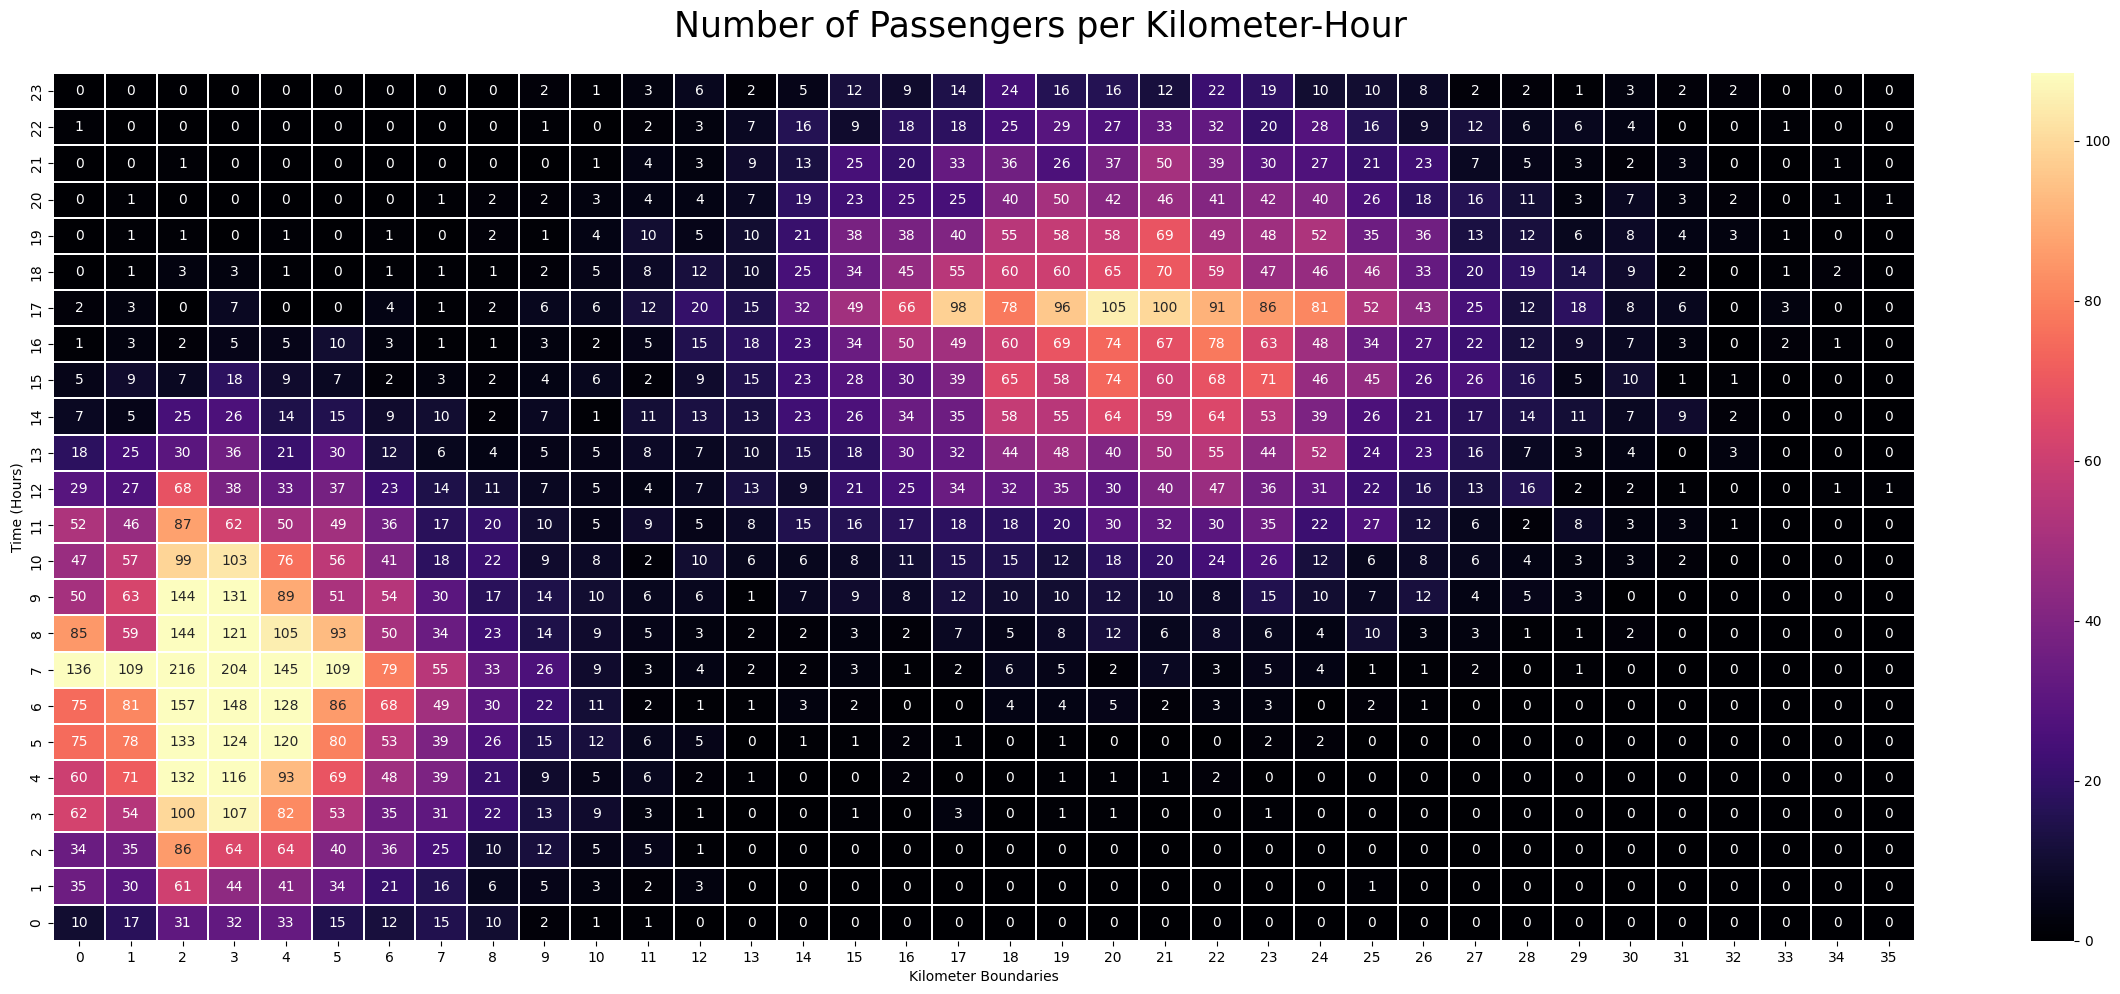

In [6]:
# Visualizing the passenger_distribution
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(passenger_distribution, annot = True, fmt = '1.0f', linewidths = 0.1, ax = ax, robust = True, cmap = 'magma')
plt.xlabel(f'{distance_unit} Boundaries')
plt.ylabel('Time (Hours)')
plt.text(12, 25, f'Number of Passengers per {distance_unit}-Hour', fontsize = 25)
ax.invert_yaxis()
fig.tight_layout()

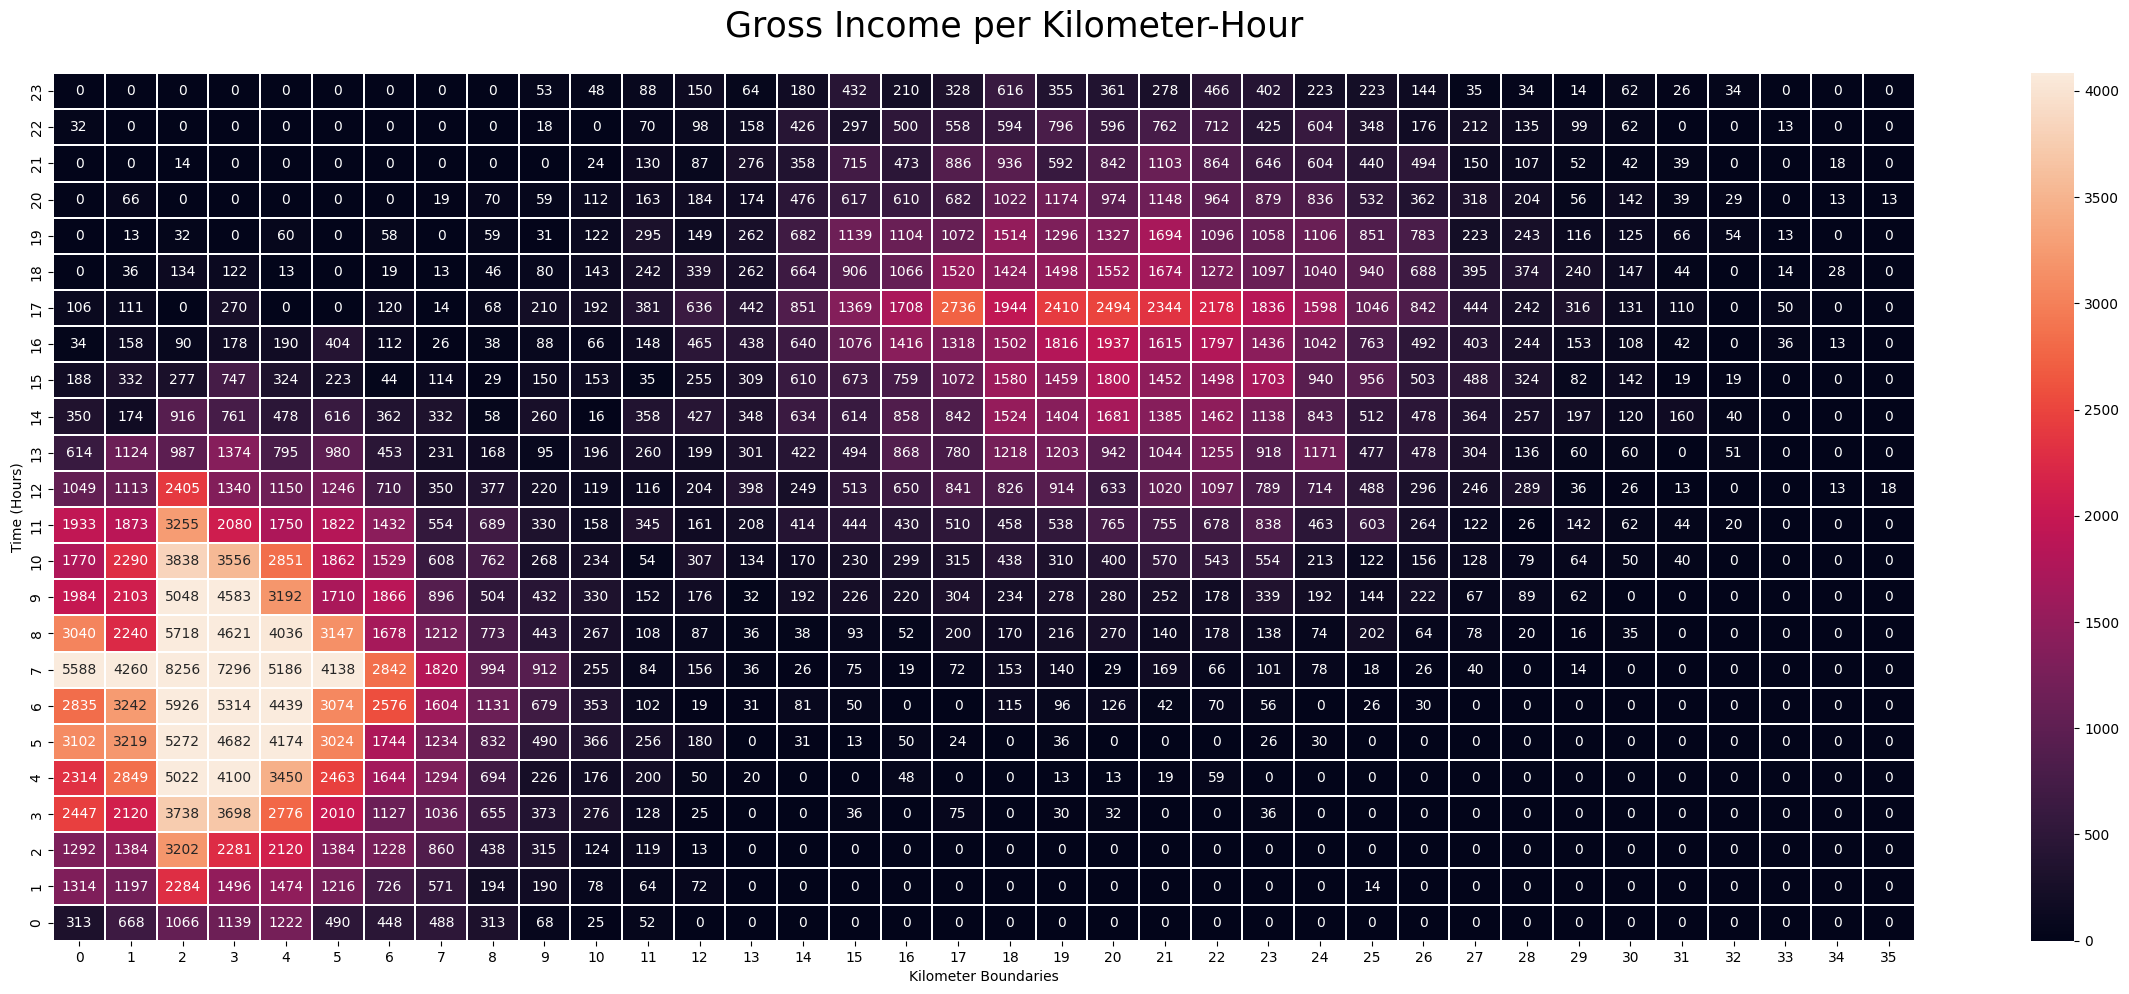

In [7]:
# Visualizing the income_distribution
fig, ax = plt.subplots(figsize=(24, 10))
sns.heatmap(income_distribution, annot = True, fmt = '1.0f', linewidths = 0.1, ax = ax, robust = True)
plt.xlabel(f'{distance_unit} Boundaries')
plt.ylabel('Time (Hours)')
plt.text(13, 25, f'Gross Income per {distance_unit}-Hour', fontsize = 25)
ax.invert_yaxis()
fig.tight_layout()

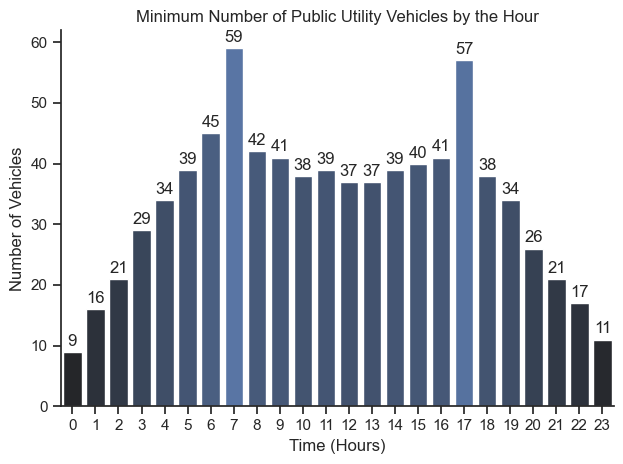

In [8]:
# Visualizing the minimum number of vehicles needed per hour
sns.set_theme(style = 'ticks')
sns.barplot(data = minimum_vehicles, x = minimum_vehicles.index, y = 'Minimum Vehicles', hue = 'Minimum Vehicles', palette = 'dark:b', legend = False)
sns.despine()
plt.xlabel('Time (Hours)')
plt.ylabel('Number of Vehicles')
plt.title('Minimum Number of Public Utility Vehicles by the Hour')

for i, value in enumerate(minimum_vehicles['Minimum Vehicles'].values.tolist()):
    plt.text(i, value + 1, value, ha = 'center')

plt.tight_layout()